In [1]:
# Linking Google drive to use preprocessed data 
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


In [2]:
# Get Resnet18 model trained on places dataset. 
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2022-06-09 19:54:47--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  73.1MB/s    in 0.6s    

2022-06-09 19:54:47 (73.1 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



# General imports

In [3]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
print ('completed cell')

completed cell


# Emotic classes

## Emotic CNN Models

## Base FN2 

In [5]:
class EmoticBase(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(EmoticBase,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)    
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


## FN3

In [6]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 512)
    self.bn1 = nn.BatchNorm1d(512)
    self.d1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(512,256)
    self.d2 = nn.Dropout(p=0.2)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    print(context_features.shape)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)

    fuse_out = self.d1(fuse_out)   
    fuse_out = self.fc2(fuse_out) 
    fuse_out = self.d2(fuse_out)
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


### Sanity check

In [6]:
# 32: batch size
# 512: in features
n_context_features = torch.rand([32, 512,1 ])
n_body_features = torch.rand([32,512,1])

In [26]:
fn3 = Emotic(512,512)

In [27]:
cat, vad = fn3(torch.rand([32, 512,1,1]),torch.rand([32, 512,1,1 ]))

torch.Size([32, 512])


In [28]:
cat.shape

torch.Size([32, 26])

## CFN3

In [7]:
class EmoticCFN(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(EmoticCFN,self).__init__()
    
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features

    self.conv1 = nn.Conv2d(1024, 256, kernel_size=2, padding=1)

    self.bn1 = nn.BatchNorm2d(256)
    self.pool1 = nn.MaxPool2d(2)

    self.d1 = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(256, 128)
    self.bn2 = nn.BatchNorm1d(128)

    #self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

    self.fc2 = nn.Linear(128,64)
    self.d2 = nn.Dropout(p=0.2)
    self.fc_cat = nn.Linear(64, 26)
    self.fc_cont = nn.Linear(64, 3)
    self.relu = nn.ReLU()

    
  def forward(self, x_context, x_body):
    fuse_features = torch.cat((x_context, x_body), 1) # [32,512,1,1] + [32,512,1,1]
    #print(fuse_features.shape)
    fuse_out = self.conv1(fuse_features)
    #print(fuse_out.shape)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.pool1(fuse_out)
    fuse_out = self.relu(fuse_out)

    fuse_out = self.d1(fuse_out)

    fuse_out = fuse_out.view(fuse_out.size(0), -1)
    #print(fuse_out.shape)

    fuse_out = self.fc1(fuse_out)
    fuse_out = self.relu(fuse_out)

    #fuse_out = self.d2(fuse_out)   

    fuse_out = self.fc2(fuse_out) 
    #print(fuse_out.shape)
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)

    return cat_out, cont_out

print ('completed cell')

completed cell


### Sanity check

In [30]:
n_context_features = torch.rand([32, 512,1,1 ])
n_body_features = torch.rand([32,512, 1,1])

In [31]:
cfn = EmoticCFN(512,512)

In [32]:
cat, vad = cfn(n_context_features, n_body_features)

In [33]:
cat.shape

torch.Size([32, 26])

In [34]:
vad.shape

torch.Size([32, 3])

## Emotic Dataset

In [8]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat 
    self.y_cont = y_cont
    self.transform = transform 
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)
  
  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


# Emotic losses

In [9]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)
    
  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum() 

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# Load preprocessed npy dataset

In [10]:
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_pre'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data 
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [11]:
batch_size = 32

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(), 
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context[:20000,:,:], train_body[:20000,:,:], train_cat[:20000,:], train_cont[:20000,:], \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  625 val loader  104 test 226
completed cell


# Prepare emotic models

## FN3

In [22]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


print(summary(model_context, (3,224,224), device="cpu"))
print(summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## CFN3

In [12]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_cfn = EmoticCFN(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


#print(summary(model_context, (3,224,224), device="cpu"))
#print(summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

completed cell


## Sanity check

In [63]:
model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

In [66]:
list(model_context.children())[-1] # last layer of model_context network

Linear(in_features=512, out_features=365, bias=True)

In [67]:
list(model_context.children())[-1].in_features

512

In [70]:
list(model_body.children())[-1].in_features

512

# Prepare loss and optimizer

## FN3

In [23]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


## CFN

In [13]:
for param in emotic_cfn.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_cfn.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# Train model

## Helper functions

In [14]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  
  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)
    
    emotic_model.train()
    model_context.train()
    model_body.train()
    
    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)
      #print(pred_context.shape, pred_body.shape)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0: 
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)

    
    running_loss = 0.0 
    emotic_model.eval()
    model_context.eval()
    model_body.eval()

    #actuals, predictions = [], []
    
    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)
        
        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)

        #actuals.extend(labels_cat.cpu().numpy().astype(int))
        #predictions.extend(F.softmax(pred_cat, 1).cpu().numpy())
        running_loss += loss.item()

      # Prepare predictions and actuals
      #predictions = np.array(predictions)
      # Choose label (array)
      #predicted_labels = predictions.argmax(1)

      # ----- Accuracy -----
      #print(predicted_labels, actuals)
      #accuracy = (predicted_labels == actuals).mean()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
      
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')
  
  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])
  return train_loss, val_loss

print ('completed cell')

completed cell


## FN3

In [ ]:
train_loss, val_loss = train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

## CFN

In [1]:
train_loss_cfn, val_loss_cfn = train_emotic(15, './models', opt, scheduler, [model_context, model_body, emotic_cfn], disc_loss, cont_loss_SL1)

NameError: ignored

# Test model

In [14]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [15]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10 
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean 

print ('completed cell')

completed cell


In [16]:
model_context_ = torch.load('./models/model_context1.pth')
model_body_ = torch.load('./models/model_body1.pth')
emotic_model_ = torch.load('./models/model_emotic1.pth')

print ('completed cell')

completed cell


In [18]:
val_ap, val_vad = test_data([model_context_, model_body_, emotic_cfn], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context_, model_body_, emotic_cfn], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.3873472  0.17469317 0.20919882 0.948776   0.13890524 0.78429466
 0.23224463 0.36073342 0.1856727  0.22455819 0.05470181 0.978687
 0.23211813 0.795418   0.12215775 0.07975958 0.8120774  0.18213622
 0.26514047 0.5039089  0.20648812 0.06567238 0.18948738 0.13478829
 0.33798882 0.11008964] (26,) 0.3352709
vad [0.7113538  0.85437226 0.8803756 ] (3,) 0.8153672
0.3352709 0.8153672
starting testing
completed testing
ap [0.27540585 0.08685982 0.1426581  0.56197596 0.0657113  0.7499784
 0.10866425 0.23696646 0.16303982 0.1838545  0.02268611 0.8640928
 0.1403799  0.6929017  0.08667089 0.05578521 0.6692081  0.07931809
 0.21447955 0.43214813 0.18127738 0.05701687 0.17801663 0.08205011
 0.11864205 0.08051747] (26,) 0.2511656
vad [0.90445465 1.0155507  0.94638526] (3,) 0.9554636
0.2511656 0.9554636
validation Mean average precision=0.3353 Mean VAD MAE=0.8154
testing Mean average precision=0.2512 Mean VAD MAE=0.9555


# Visualization

## View loss history

In [21]:
epoch_nums = np.arange(0,30)
epoch_nums

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

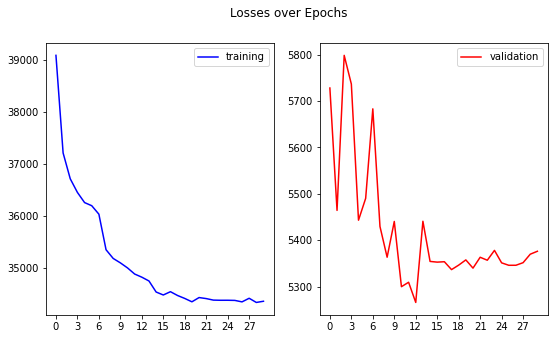

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))
f.suptitle('Losses over Epochs')
ax1.plot(epoch_nums,train_loss_cfn, color='Blue')
ax2.plot(epoch_nums,val_loss_cfn, color='Red')

ax1.legend(['training'])
ax2.legend(['validation'])

ax1.xaxis.set_ticks(np.arange(0,30,3))
ax2.xaxis.set_ticks(np.arange(0,30,3))

## View predicted labels

In [26]:
classes = list(ind2cat.values())

In [27]:
def decode_target(target,thresholds): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    #index = np.argmax(target)
    for i, x in enumerate(target):
        if (x >=thresholds[i]):
          result.append(classes[i])     
    return ' '.join(result)

In [28]:
cat_preds = np.zeros((test_dataset.__len__(), 26))
cat_labels = np.zeros((test_dataset.__len__(), 26))
indx = 0
for images_context, images_body, labels_cat, _ in iter(test_loader):

    images_context = images_context.to(device)
    images_body = images_body.to(device)

    pred_context = model_context(images_context)
    pred_body = model_body(images_body)
    pred_cat, pred_cont = emotic_cfn(pred_context, pred_body)

    cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
    cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
    indx = indx + pred_cat.shape[0]
    break


In [29]:
from torchvision.utils import make_grid

In [30]:
tmp_test_df = pd.read_csv("/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_pre/test.csv")

In [31]:
thresholds = np.load("/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic_preprocessed/val_thresholds.npy")
thresholds

array([0.11883688, 0.3242663 , 0.16440019, 0.17634252, 0.23716635,
       0.12735945, 0.20844972, 0.10896836, 0.07242661, 0.07501364,
       0.13490386, 0.47185558, 0.07762638, 0.15324497, 0.1282759 ,
       0.12901083, 0.22990082, 0.27152056, 0.10629541, 0.10588697,
       0.17268932, 0.16199018, 0.25526306, 0.10016411, 0.09835003,
       0.08961281], dtype=float32)

In [32]:
src = "/content/drive/MyDrive/Mental_health_chatbot/data/emotion_image_data/emotic"

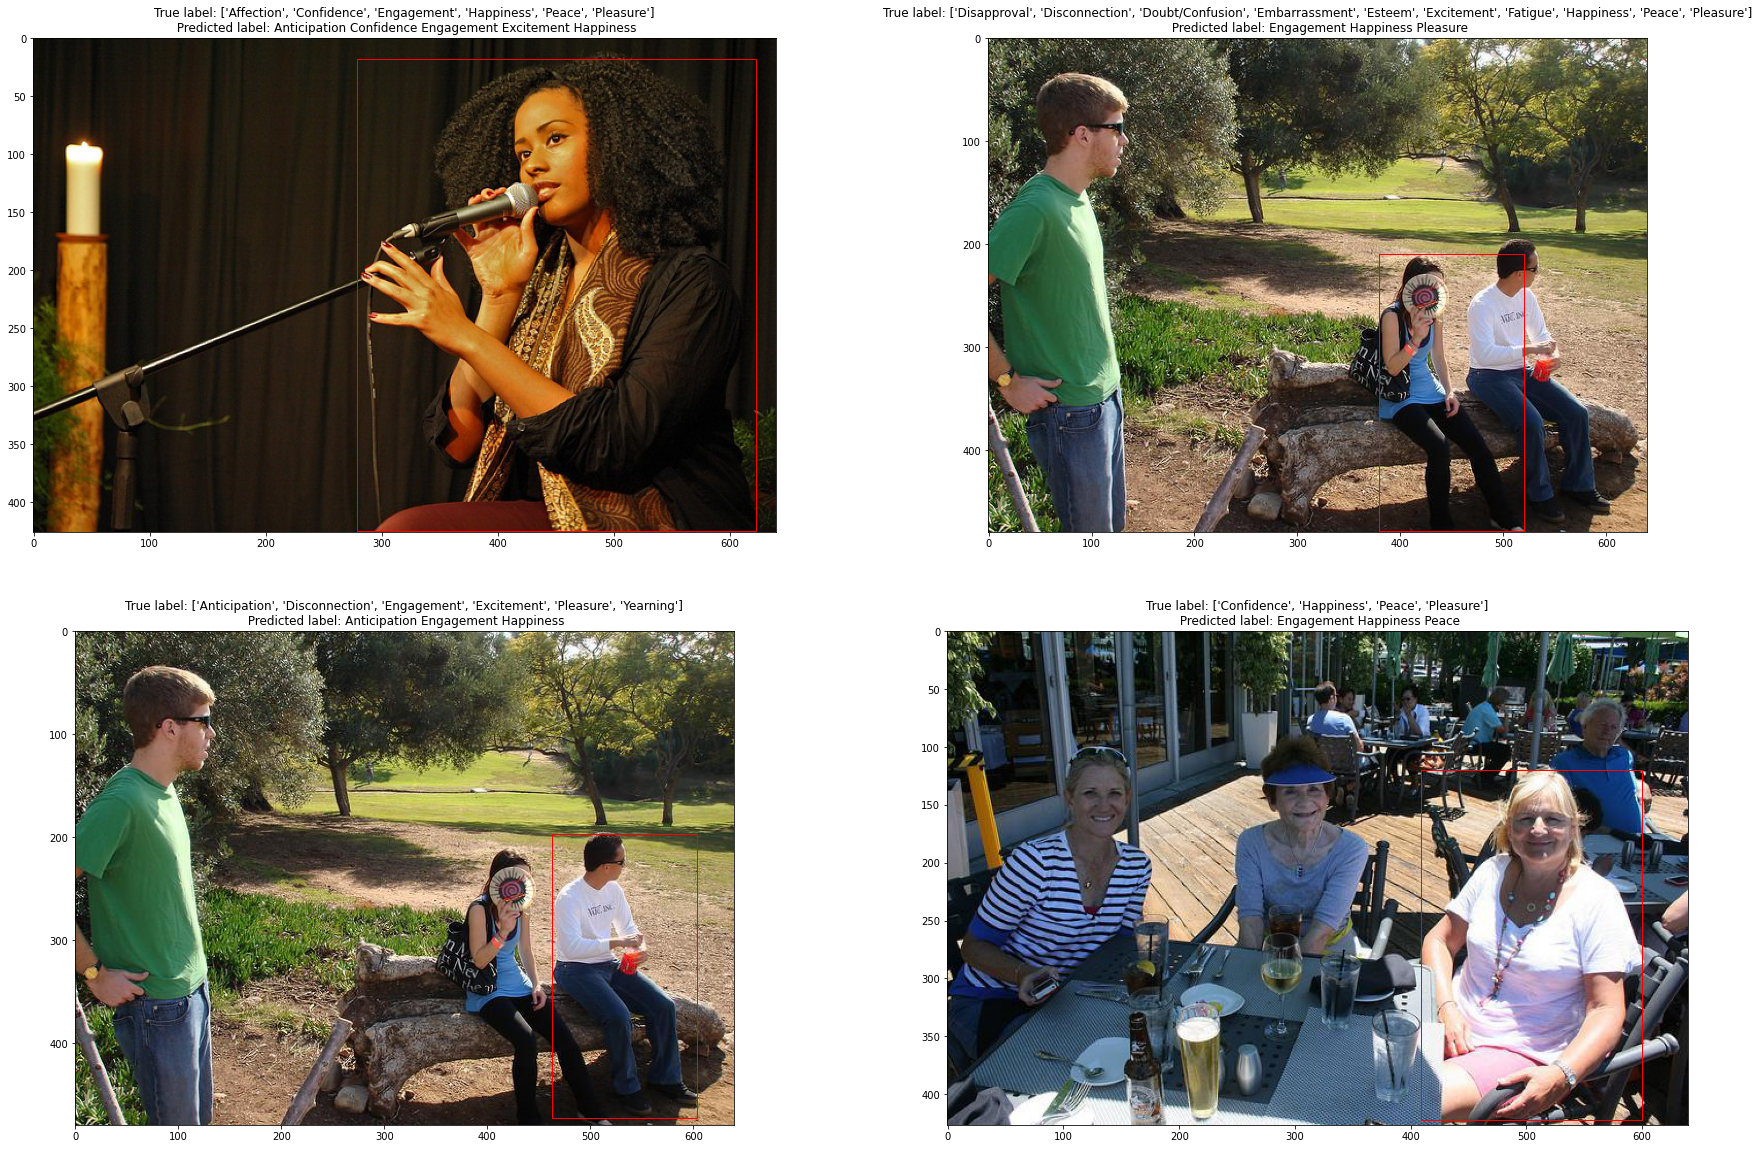

In [50]:
fig = plt.figure(figsize=(30, 20))
for i in range(5):
  image_context = Image.open(os.path.join(src, tmp_test_df['Folder'][i], tmp_test_df['Filename'][i])).convert('RGB')
  bbox = ast.literal_eval(tmp_test_df['BBox'][i])
  if i < 4:
    sub = fig.add_subplot(2,2,i+1)
    sub.imshow(image_context)

    # Create a Rectangle patch
    # ((x_1,y_1), width, height ) 
    # where width = x_2 - x_1
    # height = y_2 - y_1
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=5, edgecolor='r', facecolor='none')
    sub.add_patch(rect)
    predicted = decode_target(cat_preds[i],thresholds)
    ground_truth = tmp_test_df['Categorical_Labels'][i]
    sub.set_title(f'True label: {ground_truth}\n Predicted label: {predicted}',fontdict={'fontsize':12})